<a href="https://colab.research.google.com/github/gugupig/some_courseworks/blob/main/TianLAN_TP2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install polyglot
!pip install PyICU
!pip install pycld2
!pip install morfessor

In [ ]:
import tensorflow_datasets as tfds
import random
import polyglot
from polyglot.text import Text
from polyglot.detect.base import logger
logger.disabled = True
import sys

# **<---------- Table of content available!**

# 1 Appetizers

##Question 1

How is the TTR (type-token ratio) defined? Why is this a ‘good’ measure of the morphological complexity? Which other metric could you use to quantify morphological complexity?


TTR: The total number of uninque word types divided by the total number of word tokens in a document .

Since morphological complexity of a text can be roughly represented by how many different forms can a lemma takes,TTR can be a very intuitive choice for mesuring the morphological complexity,however,since it's a ratio,it is strongly affected by the length of the text (total number of word tokens).

Entropy is a possible metric of morphological complexity,since it mesure the level of 'chaotic' of a system,so a 'word' in a morphological more complex language has more choices, so more "chaotic'

##Question 2




Why do we consider a language modeling task?

Because a traditional LM (like the N-gram model) do not consider the sub-word level information, so it should be sensitive to the morphology complexity

## Question 3

How is the perplexity defined? Can we compare perplexity across corpora or languages?
Conclude.


the perplexity (of a LM) on a sentence ($w_1$ $w_2$ ... $w_N$) can be defined as :

$P(w_1 w_2 ... w_N)^\frac{1}{N}$

hence,the N-th root of the inversed probability (asssigned by the LM) of this sentence

For getting a meaningful comparison of perplexity across corpora or languages, it's important to keep the same vocabulary size (or at least similar) across the different corpora/languages because it has a huge impact on the performance of an LM (an LM will give a better prediction on a language that has very limited vocabulary)


## Question 4

What conclusions can you draw from Figure 1

Figure 1 shows that:
1. There is a negative correlation between morphological complexity (TTR) and the performance of an LM (perplexity). 
2. This relation is not necessarily linear : some languages (at the bottom of the figure) has relatively high TTR but the LM still perform adequately.
3. Languages in the same morphological type occupy a similar location, which means the perplexities and TTR tend to be similar for languages of the same morphological type.

## Question 5

Why will we not consider the corpus used in [1]? Why are the FAIR principles1
a solution
to this problem?

#2 Main Course

##2.1 Generating the corpora

### Question 6
Why the role of the data_dir parameter in line 3 of Figure 2? What is the meaning of its
value?


 data_dir is the path of the directory to read/write data

### Question 7
Why do we have to specify a buffer_size parameter for the shuffle method? How do
we choose its value?

buffer_size parameter for the shuffle method determines the amount of buffer elements picked from (not randomly) the source dataset, the shuffle only apply to these buffed elements, not to the entire dataset, so it affects how random the shuffling is.

the choice of buffer_size should take into account the available system memory as well as the desired randomness

### Question 8

Why do we have to extract sentences out of Wikipedia articles?

1. the N-gram model trains on sentences

2. extracting sentences from different articles make the trained LM more representative for the whole language, not a single article

### Question 9

Why do we enforce that all train and test sets have the same size?

As mentioned in Question 3, the vocabulary size heavily impacts the performance of an LM, so making all dataset the same size eliminates as much as possible the impact of vocabulary size 

(supposed different languages has a similar size of vocabulary in the same amount of text, which is a very big assumption)

### Question 10
What kind of information polyglot is using to identify sentence boundaries and segment
sentences into tokens. Comment.

According to the Polyglot document, it uses the Unicode Text Segmentation algorithm to detect sentence boundaries, it seems to me that this algorithm uses a series of rules to determine sentence boundary, the information they use are: the upper or lower case of a letter, white space etc.
see detail : http://www.unicode.org/reports/tr29/#Sentence_Boundary_Rules

###Code 11 and 13 : Data preparation
Extract sentences from data source , tokenized them and save the text file to the google drive

In [ ]:
def build_dataset(language,mode,nb):
  print( f"\n ---- [{mode}] Now processing : {language} ----" )
  data = tfds.load('wiki40b/'+language,split = mode,data_dir="gs://tfds-data/datasets")
  data = data.shuffle(buffer_size = 10000)
  generator = iter(data)
  i = 0
  file = open(language+'_'+mode,'w',encoding='utf-8')
  while i<nb:
    dupe_checker = ''
    trigger = 0
    try:
      next_article = next(generator)
    except StopIteration:
      generator = iter(data)
      next_article = next(generator)
    for sentence in next_article['text'].numpy().decode('utf-8').split('\n'):
        if sentence == '_START_PARAGRAPH_':
          trigger = 1
        if trigger == 1 and sentence not in  ['_START_ARTICLE_',"_START_SECTION_",'_START_PARAGRAPH_']:
          trigger = 0
          try:
              s = Text(sentence).sentences
              choices = random.choice(s)
              try :
                if choices[0:9] == '_NEWLINE_':
                  choices = choices[9:]
                if '_NEWLINE_' in choices:
                  choices = random.choice(s)
              except IndexError:
                pass
              words = list(choices.words)
          except:
            pass
          if len(words) >3 and words != dupe_checker:
            file.write(" ".join(words)+'\n')
            i+=1
            sys.stdout.write('\r'+str(i) + '/' + str(nb) + ' sentences added')
            sys.stdout.flush()
          if i == nb:
            break
          dupe_checker = words
  file.close()

In [ ]:
#make a liitle toy sample for testing the build funtion
#Warnig this will overwrite existed file !!!
build_dataset(language = 'en',mode = 'test',nb = 1000)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
lang_list = ['en', 'ar', 'zh-cn', 'zh-tw', 'nl', 'fr', 'de', 'it', 'ja', 'ko', 'pl', 'pt', 'ru', 'es', 'th', 'tr', 'bg', 'ca', 'cs', 'da', 'el', 'et', 'fa', 'fi', 'he', 'hi', 'hr', 'hu', 'id', 'lt', 'lv', 'ms', 'no', 'ro', 'sk', 'sl', 'sr', 'sv', 'tl', 'uk', 'vi']

In [ ]:
import shutil
lang_list_1 = lang_list.copy()
lang_list_2 = lang_list.copy()
while lang_list_1:
  language = lang_list_1.pop()
  filename = language + '_' + 'train'
  build_dataset(language = language,mode = 'train',nb = 40000)
  shutil.copy(filename, "/content/drive/MyDrive/Dataset")
while lang_list_2:
  language = lang_list_2.pop()
  filename = language + '_' + 'test'
  build_dataset(language = language,mode = 'test',nb = 3000)
  shutil.copy(filename, "/content/drive/MyDrive/Dataset")

### Question 12

Why do we have to remove duplicate sentences?

1. Duplicated sentences will affect the perfomence of the LM
2. Duplicated sentences contain duplicated words, which will affect the calculation of TTR

##2.2 Extracting morphological information

### Code 14 : Compute the TTR for all datasets

In [ ]:
def TTR(data):
  tokens = []
  with open(data,'r',encoding='utf-8') as file:
    for line in file:
      tokens = tokens + line.strip().split(' ')
  return len(list(set(tokens)))/len(tokens)

In [ ]:
import shutil
ttr_dict = {}
for lang in lang_list:
  ttr_dict[lang] = TTR('/content/'+lang+'_train')
import pickle
with open('ttr_dict.pkl','wb') as file:
  pickle.dump(ttr_dict,file)
shutil.copy('ttr_dict.pkl', "/content/drive/MyDrive/Dataset")

### Question 15 
Knowing that you will have to compute for each language its TTR and its perplexity, what
is the best way to store the TTR?


The best way to store these data is a dictionary where keys are language and the values are a tuple of (TTR, PPL)
P.S. here I use two separate dictionaries: ttr_dict and ppl_test_dict

### Code 16

Classify each language of the wiki40b corpus into one four categories



According to the document on the WALS, I choose 3 features to classify the morphological type of a language: 

1. Fusion of Selected Inflectional Formatives : Exclusively concatenative,exclusively isolating etc.

2. Exponence of Selected Inflectional Formatives : Monoexponential case ,Case + number etc.
3. Possessive Classification : No possessive classification ,Two classes etc.


In order to collect this information automatically from the WALS website. I use the feedparser library to parse the RSS feed of each language, here is the RSS feed for English:

https://wals.info/values.atom?language=eng&sEcho=1&iSortingCols=1&iSortCol_0=0&sSortDir_0=asc 

However, since the language code provided by the dataset is ISO639-1 but WALS use WALS code, additional conversion is needed please see Appendix

i only found 38 out 41(40 since WALS only has Mandarin for both zh-cn and zh-tw) 

Missing language are 'hr' and 'sr' and since Modern Standard Arabic do not have enough data on WALS , i choose Arabic (Egyptian) as a replacement for the MSA

#### Code 16.1 : Parse the RSS feed of each language and collect data


Only 20 out 41(40) language has enough information on the WALS

In [ ]:
!pip install feedparser

In [ ]:
#Before run this cell,run the wals_code cell in the appendix first
import feedparser
lang_modified  =  lang_list.copy()
for i in range(len(lang_modified)):
    if lang_modified[i]  == 'zh-tw':
        lang_modified[i] = 'zh'
    if lang_modified[i]  == 'zh-cn':
        lang_modified[i] = 'zh'


featrues_fusion = ['Exclusively concatenative','Exclusively isolating','Exclusively tonal','Tonal/isolating','Tonal/concatenative','Ablaut/concatenative','Isolating/concatenative']
featrues_exponence = ['Monoexponential case' ,'Case + number','Case + referentiality', 'Case + TAM','No case']
featrues_possessive =['No possessive classification','Two classes','Three to five classes','More than five classes']

lang_features_dict = {lang:[] for lang in lang_modified}
for lang,code in wals_code.items():
  url = f'https://wals.info/values.atom?language={code}&sEcho=1&iSortingCols=1&iSortCol_0=0&sSortDir_0=asc'
  feed = feedparser.parse(url)
  entries = feed.entries
  if len(entries) < 1000:
    for e in entries:
      for f in featrues_fusion:
        if e['title'] == f:
          lang_features_dict[lang].append(f)
          break
      for f in featrues_exponence:
        if e['title'] == f:
          lang_features_dict[lang].append(f)
          break
      for f in featrues_possessive:
        if e['title'] == f:
          lang_features_dict[lang].append(f)
          break
lang_features_dict['zh'] = list(set(lang_features_dict['zh']))
lang_features_dict['zh-tw'] = lang_features_dict['zh']
lang_features_dict['zh-cn'] = lang_features_dict['zh']
del lang_features_dict['zh']

In [ ]:
import json
#20 out of 41 languages are missing
print (json.dumps(lang_features_dict, indent=2))
missing = [i for i in lang_features_dict if lang_features_dict[i] == []]
len(missing)
#have = [i for i in lang_features_dict.keys() if i not in missing]
have = {i:j for i,j in lang_features_dict.items() if i not in missing}

In [ ]:
import pandas as pd
from tabulate import tabulate
lang_have = pd.DataFrame.from_dict(have)
print(tabulate(lang_have, headers='keys', tablefmt='psql'))

+----+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+------------------------------+
|    | en                           | ar                           | fr                           | de                           | ja                           | ko                           | ru                           | es                           | th                           | tr                           | el                       

Base on the previous information collected on the WALS, 20 languages are classified as follow:

In [ ]:
exsting_morpho_type = {'en': 'fusional',
 'ar': 'introflexive',
 'fr': 'fusional',
 'de': 'fusional',
 'ja': 'agglutinative',
 'ko': 'agglutinative',
 'ru': 'fusional',
 'es': 'fusional',
 'th': 'isolating',
 'tr': 'agglutinative',
 'el': 'fusional',
 'fa': 'fusional',
 'fi': 'agglutinative',
 'he': 'introflexive',
 'hi': 'fusional',
 'hu': 'agglutinative',
 'id': 'isolating',
 'tl': 'isolating',
 'vi': 'isolating',
 'zh-tw': 'isolating',
 'zh-cn': 'isolating'}

#### Code 16.2 : Use vec2lang database to classifier missing languages


For the rest 20 languages that are unclassifiable due to lack of information on the WALS website, I use the vec2lang database to find their features vectors as well as the features vectors for 4 reference languages ( Chinese: isolating, Turkish: agglutinative, French: fusional and  Arabic:introflexive ) for each morphological type
And then I use the k-means clustering algorithm to cluster these 24 vectors into 4 groups, language in the same group with the reference language will be categorized as the same morphological type

In [ ]:
!pip install lang2vec

In [ ]:
import lang2vec.lang2vec as l2v
features_knn = l2v.get_features(lang_modified, "syntax_knn", header=False)
features_knn.keys()
zh = features_knn['zh']
features_knn['zh-cn'] = zh
features_knn['zh-tw'] = zh
del features_knn['zh']

In [ ]:
from sklearn.cluster import KMeans
import numpy as np
features_knn = {k:np.array(v) for k,v in features_knn.items()}
kmeans = KMeans(n_clusters=4, random_state=0).fit(list(features_knn.values()))
catagorized = {lang:label for lang,label in zip(list(features_knn.keys()),kmeans.labels_)}
reference_language  = {'tr':"agglutinative",'zh-cn':"isolating",'fr':"fusional",'ar':"introflexive"}
morpho_types = ["introflexive","agglutinative","fusional","isolating"]
lang_morpho_type_= {lang:morpho_types[catagorized[lang]] for lang in catagorized}
missing__morpho_type = {l:m for l,m in lang_morpho_type_.items() if l in missing}
missing__morpho_type

{'bg': 'fusional',
 'ca': 'fusional',
 'cs': 'agglutinative',
 'da': 'fusional',
 'et': 'fusional',
 'hr': 'fusional',
 'it': 'fusional',
 'lt': 'agglutinative',
 'lv': 'agglutinative',
 'ms': 'introflexive',
 'nl': 'fusional',
 'no': 'fusional',
 'pl': 'fusional',
 'pt': 'fusional',
 'ro': 'fusional',
 'sk': 'fusional',
 'sl': 'fusional',
 'sr': 'fusional',
 'sv': 'fusional',
 'uk': 'fusional'}

In [ ]:
#Combine 2 dictionaries together
lang_morpho_type = {**missing__morpho_type,**exsting_morpho_type}
lang_morpho_type

{'ar': 'introflexive',
 'bg': 'fusional',
 'ca': 'fusional',
 'cs': 'agglutinative',
 'da': 'fusional',
 'de': 'fusional',
 'el': 'fusional',
 'en': 'fusional',
 'es': 'fusional',
 'et': 'fusional',
 'fa': 'fusional',
 'fi': 'agglutinative',
 'fr': 'fusional',
 'he': 'introflexive',
 'hi': 'fusional',
 'hr': 'fusional',
 'hu': 'agglutinative',
 'id': 'isolating',
 'it': 'fusional',
 'ja': 'agglutinative',
 'ko': 'agglutinative',
 'lt': 'agglutinative',
 'lv': 'agglutinative',
 'ms': 'introflexive',
 'nl': 'fusional',
 'no': 'fusional',
 'pl': 'fusional',
 'pt': 'fusional',
 'ro': 'fusional',
 'ru': 'fusional',
 'sk': 'fusional',
 'sl': 'fusional',
 'sr': 'fusional',
 'sv': 'fusional',
 'th': 'isolating',
 'tl': 'isolating',
 'tr': 'agglutinative',
 'uk': 'fusional',
 'vi': 'isolating',
 'zh-cn': 'isolating',
 'zh-tw': 'isolating'}

## Question 17
What structure should you use to store this information? Why?

I use a dictionary {language : morphological type} to store this information for fast indexing

##2.3 Training and evaluating language models 

##Code 18 : Install kenlm


In [ ]:
!git clone https://github.com/kpu/kenlm.git
%cd kenlm
!python setup.py develop
!mkdir -p build
%cd build
!cmake ..
!make -j 4

## Question 19 
Why do some shell commands in Figure 3 starts with a ! and others with a %?

the prefix "!" starts a new shell while the prefix "%" dose not and it only applies to the current shell

## Question 20 
Why the python interface of kenlm allows you to compute the perplexity of a model but
not to estimate its parameters?

In fact, the documentation for the Python interface is very lacking, the dir(kenlm) reveals that there is no training method built in the Python interface,
so my guess is training the model requires some dependencies that Python can not provide

## Code 21,22 : Train a 5gram language model for each language


In [ ]:
ngram  =  5
for lang in lang_list:
  input_file = lang+'_train'
  output_file = lang+'_train'
  !/content/kenlm/build/bin/lmplz -o {ngram} </content/{input_file}>  /content/{output_file}_{ngram}gram.arpa

In [ ]:
# This shows all 5gram files and their size
!find *_5gram.arpa| xargs du -sh

221M	ar_train_5gram.arpa
273M	ar_train_bpe_5gram.arpa
133M	bg_train_5gram.arpa
165M	bg_train_bpe_5gram.arpa
109M	ca_train_5gram.arpa
143M	ca_train_bpe_5gram.arpa
115M	cs_train_5gram.arpa
155M	cs_train_bpe_5gram.arpa
113M	da_train_5gram.arpa
152M	da_train_bpe_5gram.arpa
111M	de_train_5gram.arpa
146M	de_train_bpe_5gram.arpa
186M	el_train_5gram.arpa
228M	el_train_bpe_5gram.arpa
121M	en_train_5gram.arpa
160M	en_train_bpe_5gram.arpa
136M	es_train_5gram.arpa
180M	es_train_bpe_5gram.arpa
104M	et_train_5gram.arpa
140M	et_train_bpe_5gram.arpa
150M	fa_train_5gram.arpa
184M	fa_train_bpe_5gram.arpa
98M	fi_train_5gram.arpa
133M	fi_train_bpe_5gram.arpa
125M	fr_train_5gram.arpa
164M	fr_train_bpe_5gram.arpa
151M	he_train_5gram.arpa
188M	he_train_bpe_5gram.arpa
182M	hi_train_5gram.arpa
219M	hi_train_bpe_5gram.arpa
86M	hr_train_5gram.arpa
115M	hr_train_bpe_5gram.arpa
108M	hu_train_5gram.arpa
143M	hu_train_bpe_5gram.arpa
118M	id_train_5gram.arpa
153M	id_train_bpe_5gram.arpa
144M	it_train_5gram.arpa
187M	

In [ ]:
#Calculate the average perplexity on the test set 
from kenlm import kenlm
ppl_test = {lang:0 for lang in lang_list}
for lang in lang_list:
  m = kenlm.Model(f"/content/{lang}_train_5gram.arpa")
  with open ('/content/'+lang+'_test','r') as file:
    print(f" -- Now Calculating perplexity for {lang} --- ")
    text = str(list(file.readlines()))
    ppl_ = m.perplexity(text)
    ppl_test[lang] = ppl_
    print(f"{lang} : {ppl_test[lang]}")
    



 -- Now Calculating perplexity for en --- 
en : 1473.731709048924
 -- Now Calculating perplexity for ar --- 
ar : 4753.527661772921
 -- Now Calculating perplexity for zh-cn --- 
zh-cn : 1021.393031632241
 -- Now Calculating perplexity for zh-tw --- 
zh-tw : 1291.8976193959807
 -- Now Calculating perplexity for nl --- 
nl : 1428.1917460793647
 -- Now Calculating perplexity for fr --- 
fr : 906.8607178417897
 -- Now Calculating perplexity for de --- 
de : 2904.670403535546
 -- Now Calculating perplexity for it --- 
it : 1330.7253670684954
 -- Now Calculating perplexity for ja --- 
ja : 522.6769689318078
 -- Now Calculating perplexity for ko --- 
ko : 13967.569542174766
 -- Now Calculating perplexity for pl --- 
pl : 3881.421899564924
 -- Now Calculating perplexity for pt --- 
pt : 908.4156104870978
 -- Now Calculating perplexity for ru --- 
ru : 3108.4576704059127
 -- Now Calculating perplexity for es --- 
es : 831.4735085902306
 -- Now Calculating perplexity for th --- 
th : 270.1973515

#3 Dersert Desert

## Code 23 : Plot


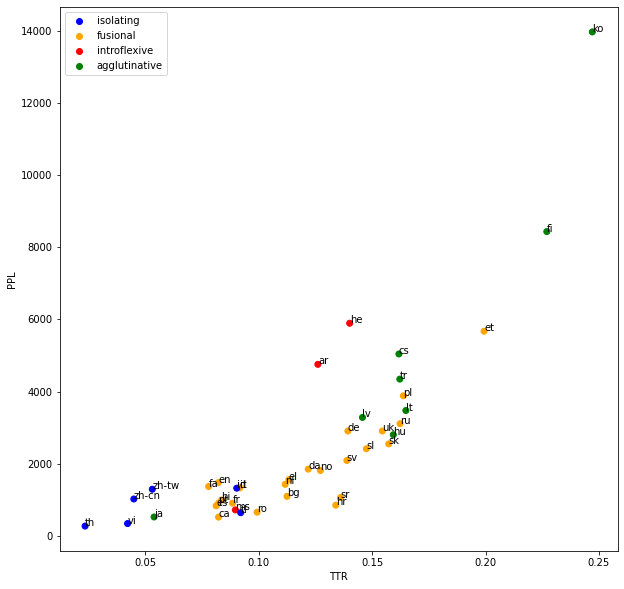

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
morphos_mark = ["isolating","fusional","introflexive","agglutinative"]
ttr  = []
ppl = []
color_values = []
color_map = ListedColormap(['b','orange','r','g'])
plt.figure(figsize=(10,10))
for lang in lang_list:
  ttr.append(ttr_dict[lang])
  ppl.append(ppl_test[lang])
  color_values.append(morphos_mark.index(lang_morpho_type[lang]))

#scatter  = plt.scatter(ttr,ppl,c = colors)
scatter  = plt.scatter(ttr,ppl,c = color_values,cmap = color_map)
plt.legend(handles=scatter.legend_elements()[0], labels=morphos_mark)
plt.xlabel('TTR')
plt.ylabel('PPL')
for i, txt in enumerate(lang_list):
    plt.annotate(txt, (ttr[i], ppl[i]))

## Code 24 : Sentencepiece

In [ ]:
% pip install sentencepiece
!sudo apt-get install cmake build-essential pkg-config libgoogle-perftools-dev

In [ ]:
! git clone https://github.com/google/sentencepiece.git 
% cd sentencepiece
% mkdir build
% cd build
! cmake ..
! make -j $(nproc)
! sudo make install
! sudo ldconfig -v

### Code 24.1 : Train the BPE tokenizer

In [ ]:
%cd /content/
for lang in lang_list:
  ! spm_train --input=/content/{lang}_train --model_prefix={lang}_bpe --vocab_size=32000 --character_coverage=0.9995 --model_type='bpe'
!cp /content/*.model  /content/drive/MyDrive/Dataset/
!cp /content/*.vocab  /content/drive/MyDrive/Dataset/

### Code 24.2 : Build dataset using trained BPE tokenizer

In [ ]:
import sentencepiece as spm
%cd /content/
for lang in lang_list:
  input_file = '/content/'+lang+'_train'
  output_file = '/content/'+lang+'_train_bpe'
  model = lang+'_bpe.model'
  lm = spm.SentencePieceProcessor(model_file = model)
  print(f" --- Now processing {lang} --- ")
  with open(input_file,'r',encoding='utf-8') as file1 , open(output_file,'w',encoding = 'utf-8') as file2:
    i = 0
    for line in file1.readlines():
      file2.write(" ".join(lm.encode(line,out_type = str))+'\n')
      i += 1
      sys.stdout.write('\r'+str(i) + '/' + str(40000) + ' sentences added')
      sys.stdout.flush()
  !cp {output_file} /content/drive/MyDrive/Dataset/    

 --- Now processing en --- 
40000/40000 sentences added --- Now processing ar --- 
40000/40000 sentences added --- Now processing zh-cn --- 
40000/40000 sentences added --- Now processing zh-tw --- 
40000/40000 sentences added --- Now processing nl --- 
40000/40000 sentences added --- Now processing fr --- 
40010/40000 sentences added --- Now processing de --- 
40000/40000 sentences added --- Now processing it --- 
40000/40000 sentences added --- Now processing ja --- 
40000/40000 sentences added --- Now processing ko --- 
40000/40000 sentences added --- Now processing pl --- 
40000/40000 sentences added --- Now processing pt --- 
40000/40000 sentences added --- Now processing ru --- 
40000/40000 sentences added --- Now processing es --- 
40000/40000 sentences added --- Now processing th --- 
40000/40000 sentences added --- Now processing tr --- 
40000/40000 sentences added --- Now processing bg --- 
40000/40000 sentences added --- Now processing ca --- 
40000/40000 sentences added ---

In [ ]:
import sentencepiece as spm
%cd /content/
for lang in lang_list:
  input_file = '/content/'+lang+'_test'
  output_file = '/content/'+lang+'_test_bpe'
  model = lang+'_bpe.model'
  lm = spm.SentencePieceProcessor(model_file = model)
  print(f" --- Now processing {lang} --- \n")
  with open(input_file,'r',encoding='utf-8') as file1 , open(output_file,'w',encoding = 'utf-8') as file2:
    i = 0
    for line in file1.readlines():
      file2.write(" ".join(lm.encode(line,out_type = str))+'\n')
      i += 1
      sys.stdout.write('\r'+str(i) + '/' + str(3000) + ' sentences added')
      sys.stdout.flush()
  !cp {output_file} /content/drive/MyDrive/Dataset/  

/content
 --- Now processing en --- 

3000/3000 sentences added --- Now processing ar --- 

3000/3000 sentences added --- Now processing zh-cn --- 

3000/3000 sentences added --- Now processing zh-tw --- 

3000/3000 sentences added --- Now processing nl --- 

3000/3000 sentences added --- Now processing fr --- 

3000/3000 sentences added --- Now processing de --- 

3000/3000 sentences added --- Now processing it --- 

3000/3000 sentences added --- Now processing ja --- 

3000/3000 sentences added --- Now processing ko --- 

3000/3000 sentences added --- Now processing pl --- 

3000/3000 sentences added --- Now processing pt --- 

3000/3000 sentences added --- Now processing ru --- 

3000/3000 sentences added --- Now processing es --- 

3000/3000 sentences added --- Now processing th --- 

3000/3000 sentences added --- Now processing tr --- 

3000/3000 sentences added --- Now processing bg --- 

3000/3000 sentences added --- Now processing ca --- 

3000/3000 sentences added --- Now proc

### Code 24.3 : Train LM using new BPE dataset

In [ ]:
from kenlm import kenlm
ngram  =  3
for lang in lang_list:
  input_file = lang+'_train_bpe'
  output_file = lang+'_train_bpe'
  !/content/kenlm/build/bin/lmplz -o {ngram} </content/{input_file}>  /content/{output_file}_{ngram}gram.arpa

### Code 24.4 : Calculate new PPL


In [ ]:
from kenlm import kenlm
ppl_test_bpe = {lang:0 for lang in lang_list}
for lang in lang_list:
  m = kenlm.Model(f"/content/{lang}_train_bpe_5gram.arpa")
  with open ('/content/'+lang+'_test_bpe','r') as file:
    print(f" -- Now Calculating perplexity for {lang} --- ")
    text = str(list(file.readlines()))
    ppl_ = m.perplexity(text)
    ppl_test_bpe[lang] = ppl_
    print(f"{lang} : {ppl_test_bpe[lang]}")

 -- Now Calculating perplexity for en --- 
en : 1035.5534193178894
 -- Now Calculating perplexity for ar --- 
ar : 1481.7814707902187
 -- Now Calculating perplexity for zh-cn --- 
zh-cn : 823.1529634338241
 -- Now Calculating perplexity for zh-tw --- 
zh-tw : 937.3196271286985
 -- Now Calculating perplexity for nl --- 
nl : 960.815231310801
 -- Now Calculating perplexity for fr --- 
fr : 437.3366919608135
 -- Now Calculating perplexity for de --- 
de : 1483.4909439584228
 -- Now Calculating perplexity for it --- 
it : 721.1202236282238
 -- Now Calculating perplexity for ja --- 
ja : 449.39738779024526
 -- Now Calculating perplexity for ko --- 
ko : 2423.890696081002
 -- Now Calculating perplexity for pl --- 
pl : 1394.5037223711406
 -- Now Calculating perplexity for pt --- 
pt : 628.4916088035345
 -- Now Calculating perplexity for ru --- 
ru : 1411.8693812653923
 -- Now Calculating perplexity for es --- 
es : 574.2721276362647
 -- Now Calculating perplexity for th --- 
th : 228.9994065

### Code 24.5 Plot a new figure

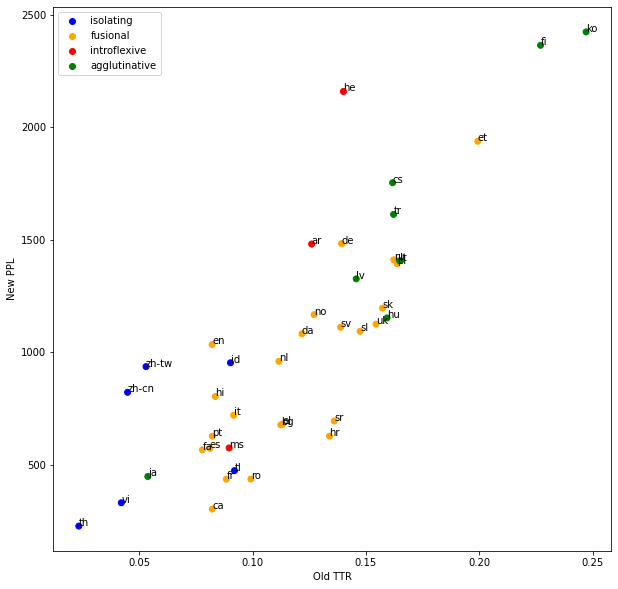

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
morphos_mark = ["isolating","fusional","introflexive","agglutinative"]
ttr  = []
ppl = []
color_values = []
color_map = ListedColormap(['b','orange','r','g'])
plt.figure(figsize=(10,10))
for lang in lang_list:
  ttr.append(ttr_dict[lang])
  ppl.append(ppl_test_bpe[lang])
  color_values.append(morphos_mark.index(lang_morpho_type[lang]))

scatter  = plt.scatter(ttr,ppl,c = color_values,cmap = color_map)
plt.legend(handles=scatter.legend_elements()[0], labels=morphos_mark)
plt.xlabel('Old TTR')
plt.ylabel('New PPL')
for i, txt in enumerate(lang_list):
    plt.annotate(txt, (ttr[i], ppl[i]))

# Appendix

## Code : WALS_code
A dictionary to convert ISO639-1 code to WALS code

In [ ]:
wals_code = {'en': 'eng',
 'ar': 'aeg',
 'zh': 'mnd',
 'nl': 'dli',
 'fr': 'fre',
 'de': 'ger',
 'it': 'ita',
 'ja': 'jpn',
 'ko': 'kor',
 'pl': 'pol',
 'pt': 'por',
 'ru': 'rus',
 'es': 'spa',
 'th': 'tha',
 'tr': 'tur',
 'bg': 'bul',
 'ca': 'ctl',
 'cs': 'cze',
 'da': 'dsh',
 'el': 'grk',
 'et': 'est',
 'fa': 'prs',
 'fi': 'fin',
 'he': 'heb',
 'hi': 'hin',
 'hu': 'hun',
 'id': 'ind',
 'lt': 'lit',
 'lv': 'lat',
 'ms': 'mly',
 'no': 'nor',
 'ro': 'rom',
 'sk': 'svk',
 'sl': 'slo',
 'sv': 'swe',
 'tl': 'tag',
 'uk': 'ukr',
 'vi': 'vie'}

## Code : use to convert ISO639-1 language code to WALS code

i ran this code on my local computer,so it's not tested on Colab

In [ ]:
%cd /content/
!wget https://zenodo.org/record/3731125/files/cldf-datasets/wals-v2020.zip?download=1
!unzip "/content/wals-v2020.zip" -d "/content/wals/
!cp /content/wals/cldf-datasets-wals-014143f/cldf/language.csv /content/
!cp /content/wals/cldf-datasets-wals-014143f/raw/walslanguage.csv /content/


lang  = pd.read_csv("language.csv")
iso_lang = pd.read_csv("walslanguage.csv")

lang_wals = lang['id'].to_list()
lang_name = lang['name'].to_list()

lang_iso = iso_lang['iso_codes'].to_list()
langname_iso = iso_lang['ascii_name'].to_list()


lang_wals_dict = {l.lower():w for l,w in zip(lang_name,lang_wals)}
lang_iso_dict = {l:i for l,i in zip(langname_iso,lang_iso)}

iso2wals = {}
for lang in lang_wals_dict.keys():
    try:
        iso2wals[lang_iso_dict[lang]] = lang_wals_dict[lang]
    except:

In [ ]:
wals_codes = {}
nto_found = []
for lang  in lang_modified:
    if ISO_639_1_TO_3[lang] in iso2wals:
        wals_codes[lang] = iso2wals[ISO_639_1_TO_3[lang]]
    else:
        not_found.append(lang)

In [ ]:
lang_modified  =  lang_list.copy()
for i in range(len(lang_modified)):
    if lang_modified[i]  == 'zh-tw':
        lang_modified[i] = 'zh'
    if lang_modified[i]  == 'zh-cn':
        lang_modified[i] = 'zh'

In [ ]:
lang_list = ['en', 'ar', 'zh-cn', 'zh-tw', 'nl', 'fr', 'de', 'it', 'ja', 'ko', 'pl', 'pt', 'ru', 'es', 'th', 'tr', 'bg', 'ca', 'cs', 'da', 'el', 'et', 'fa', 'fi', 'he', 'hi', 'hr', 'hu', 'id', 'lt', 'lv', 'ms', 'no', 'ro', 'sk', 'sl', 'sr', 'sv', 'tl', 'uk', 'vi']
ISO_639_1_TO_3 = {
    'aa': 'aar',
    'ab': 'abk',
    'ae': 'ave',
    'af': 'afr',
    'ak': 'aka',
    'am': 'amh',
    'an': 'arg',
    'ar': 'arb',
    'as': 'asm',
    'av': 'ava',
    'ay': 'aym',
    'az': 'aze',
    'ba': 'bak',
    'be': 'bel',
    'bg': 'bul',
    'bi': 'bis',
    'bm': 'bam',
    'bn': 'ben',
    'bo': 'bod',
    'br': 'bre',
    'bs': 'bos',
    'ca': 'cat',
    'ce': 'che',
    'ch': 'cha',
    'co': 'cos',
    'cr': 'cre',
    'cs': 'ces',
    'cu': 'chu',
    'cv': 'chv',
    'cy': 'cym',
    'da': 'dan',
    'de': 'deu',
    'dv': 'div',
    'dz': 'dzo',
    'ee': 'ewe',
    'el': 'ell',
    'en': 'eng',
    'eo': 'epo',
    'es': 'spa',
    'et': 'est',
    'eu': 'eus',
    'fa': 'pes',
    'ff': 'ful',
    'fi': 'fin',
    'fj': 'fij',
    'fo': 'fao',
    'fr': 'fra',
    'fy': 'fry',
    'ga': 'gle',
    'gd': 'gla',
    'gl': 'glg',
    'gn': 'grn',
    'gu': 'guj',
    'gv': 'glv',
    'ha': 'hau',
    'he': 'heb',
    'hi': 'hin',
    'ho': 'hmo',
    'hr': 'hrv',
    'ht': 'hat',
    'hu': 'hun',
    'hy': 'hye',
    'hz': 'her',
    'ia': 'ina',
    'id': 'ind',
    'ie': 'ile',
    'ig': 'ibo',
    'ii': 'iii',
    'ik': 'ipk',
    'io': 'ido',
    'is': 'isl',
    'it': 'ita',
    'iu': 'iku',
    'ja': 'jpn',
    'jv': 'jav',
    'ka': 'kat',
    'kg': 'kon',
    'ki': 'kik',
    'kj': 'kua',
    'kk': 'kaz',
    'kl': 'kal',
    'km': 'khm',
    'kn': 'kan',
    'ko': 'kor',
    'kr': 'kau',
    'ks': 'kas',
    'ku': 'kur',
    'kv': 'kom',
    'kw': 'cor',
    'ky': 'kir',
    'la': 'lat',
    'lb': 'ltz',
    'lg': 'lug',
    'li': 'lim',
    'ln': 'lin',
    'lo': 'lao',
    'lt': 'lit',
    'lu': 'lub',
    'lv': 'lav',
    'mg': 'mlg',
    'mh': 'mah',
    'mi': 'mri',
    'mk': 'mkd',
    'ml': 'mal',
    'mn': 'mon',
    'mr': 'mar',
    'ms': 'zsm',
    'mt': 'mlt',
    'my': 'mya',
    'na': 'nau',
    'nb': 'nob',
    'nd': 'nde',
    'ne': 'nep',
    'ng': 'ndo',
    'nl': 'nld',
    'nn': 'nno',
    'no': 'nob',
    'nr': 'nbl',
    'nv': 'nav',
    'ny': 'nya',
    'oc': 'oci',
    'oj': 'oji',
    'om': 'orm',
    'or': 'ori',
    'os': 'oss',
    'pa': 'pan',
    'pi': 'pli',
    'pl': 'pol',
    'ps': 'pus',
    'pt': 'por',
    'qu': 'que',
    'rm': 'roh',
    'rn': 'run',
    'ro': 'ron',
    'ru': 'rus',
    'rw': 'kin',
    'sa': 'san',
    'sc': 'srd',
    'sd': 'snd',
    'se': 'sme',
    'sg': 'sag',
    'sh': 'hbs',
    'si': 'sin',
    'sk': 'slk',
    'sl': 'slv',
    'sm': 'smo',
    'sn': 'sna',
    'so': 'som',
    'sq': 'sqi',
    'sr': 'srp',
    'ss': 'ssw',
    'st': 'sot',
    'su': 'sun',
    'sv': 'swe',
    'sw': 'swa',
    'ta': 'tam',
    'te': 'tel',
    'tg': 'tgk',
    'th': 'tha',
    'ti': 'tir',
    'tk': 'tuk',
    'tl': 'tgl',
    'tn': 'tsn',
    'to': 'ton',
    'tr': 'tur',
    'ts': 'tso',
    'tt': 'tat',
    'tw': 'twi',
    'ty': 'tah',
    'ug': 'uig',
    'uk': 'ukr',
    'ur': 'urd',
    'uz': 'uzb',
    've': 'ven',
    'vi': 'vie',
    'vo': 'vol',
    'wa': 'wln',
    'wo': 'wol',
    'xh': 'xho',
    'yi': 'yid',
    'yo': 'yor',
    'za': 'zha',
    'zh': 'cmn',
    'zu': 'zul'}